# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Описание данных:
Данные геологоразведки трёх регионов находятся в файлах:
* /datasets/geo_data_0.csv.
* /datasets/geo_data_1.csv. 
* /datasets/geo_data_2.csv.

In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error

In [3]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
df_0.info()
df_1.info()
df_2.info()
display(df_0.head())
display(df_1.head())
display(df_2.head())
%%time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


UsageError: Line magic function `%%time` not found.


* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

В каждом из датасетов по регионам 10000 записей. 
Тип данных float64

Проверим на наличие дубликатов

In [3]:
display(df_0.duplicated().sum(), df_1.duplicated().sum(), df_2.duplicated().sum())

0

0

0

Дубликаты строк отсутствуют

### Анализ данных

Рассмотрим сводную статистику по каждому из регионов

In [4]:
df_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [5]:
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


In [6]:
df_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Рассмотрим корреляцию целевого показателя `product` от `f0`, `f1`, `f2`

<AxesSubplot:>

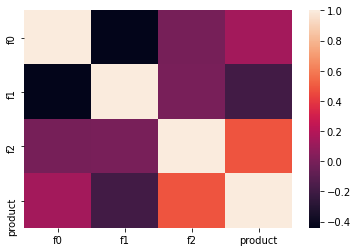

In [7]:
sns.heatmap(df_0.corr())

Корреляция  целевого показателя `product` от  `f2` средняя, по остальным - низкая 

<AxesSubplot:>

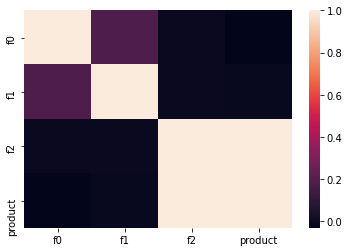

In [8]:
sns.heatmap(df_1.corr())

Корреляция  целевого показателя `product` от  `f2` очень высокая, по остальным - очень слабая

<AxesSubplot:>

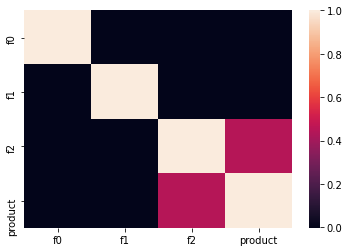

In [9]:
sns.heatmap(df_2.corr())

Корреляция  целевого показателя `product` от  `f2` средняя, по остальным - очень слабая

## Обучение и проверка модели

### Создание выборок
Разбьем данные на обучающую и валидационную выборки в соотношении 75:25 по каждому региону


In [10]:
def split_data(data, target_column):
    return data.drop(columns=[target_column, 'id'], axis=1), data[target_column]

In [11]:
features_0, target_0 = split_data(df_0,'product')
features_1, target_1 = split_data(df_1,'product')
features_2, target_2 = split_data(df_2,'product')

In [12]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = ( 
                                train_test_split(
                                features_0, target_0, test_size=0.25, random_state=12345)
)

In [13]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = ( 
                                train_test_split(
                                features_1, target_1, test_size=0.25, random_state=12345)
)

In [14]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = ( 
                                train_test_split(
                                features_2, target_2, test_size=0.25, random_state=12345)
)

Проверим размер выборок

In [15]:
print(features_train_0.shape, features_valid_0.shape, target_train_0.shape, target_valid_0.shape)
print(features_train_1.shape, features_valid_1.shape, target_train_1.shape, target_valid_1.shape)
print(features_train_2.shape, features_valid_2.shape, target_train_2.shape, target_valid_2.shape)

(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)


### Модель
Обучим модель и сделаем предсказания на валидационной выборке.


In [16]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)


predicted_valid_0 = model_0.predict(features_valid_0)
rmse_0 = sqrt(mean_squared_error(target_valid_0, predicted_valid_0))
target_mean_0 = target_valid_0.mean()
predicted_mean_0 = predicted_valid_0.mean()
print("Регион 1")
print("RMSE:", rmse_0)
print("Средний запас:", target_mean_0)
print("Средний запас предсказанного сырья", predicted_mean_0)

Регион 1
RMSE: 37.5794217150813
Средний запас: 92.07859674082927
Средний запас предсказанного сырья 92.59256778438035


In [17]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)

predicted_valid_1 = model_1.predict(features_valid_1)
rmse_1 = sqrt(mean_squared_error(target_valid_1, predicted_valid_1))
target_mean_1 = target_valid_1.mean()
predicted_mean_1 = predicted_valid_1.mean()
print("Регион 2")
print("RMSE:", rmse_1)
print("Средний запас:", target_mean_1)
print("Средний запас предсказанного сырья:", predicted_mean_1)

Регион 2
RMSE: 0.893099286775617
Средний запас: 68.72313602435997
Средний запас предсказанного сырья: 68.728546895446


In [18]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)

predicted_valid_2 = model_2.predict(features_valid_2)
rmse_2 = sqrt(mean_squared_error(target_valid_2, predicted_valid_2))
target_mean_2 = target_valid_2.mean()
predicted_mean_2 = predicted_valid_0.mean()
print("Регион 3")
print("RMSE:", rmse_2)
print("Средний запас:", target_mean_2)
print("Средний запас предсказанного сырья:", predicted_mean_2)

Регион 3
RMSE: 40.02970873393434
Средний запас: 94.88423280885438
Средний запас предсказанного сырья: 92.59256778438035


In [19]:
display(pd.DataFrame({ 'RMSE': [rmse_0, rmse_1, rmse_2], 
'Средний запас':[target_mean_0, target_mean_1, target_mean_2], 
'Средний запас предсказанного сырья': [predicted_mean_0, predicted_mean_1, predicted_mean_2]}, index = ['Регион 1', 'Регион 2', 'Регион 3' ] ))

,RMSE,Средний запас,Средний запас предсказанного сырья
Регион 1,37.579422,92.078597,92.592568
Регион 2,0.893099,68.723136,68.728547
Регион 3,40.029709,94.884233,92.592568


Более точно предсказаны данные по второму региону. Далее по точности идет первый регион. Меньше всего точность по данным третьего региона. 

## Подготовка к расчёту прибыли

### Рассчет достаточного объёма сырья для безубыточной разработки новой скважины 
Расчитаем объёма сырья для безубыточной разработки новой скважины.

Сравним полученный объём сырья со средним запасом в каждом регионе.

Исходные данные: 
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [20]:
revenue_unit = 450000
cost_all = 10000000000
count_borehole = 200

Средняя добыча по регионам

In [21]:
product_0 = df_0['product'].mean()
product_1 = df_1['product'].mean()
product_2 = df_2['product'].mean()
print('Регион 1:', product_0, 'Регион 2:', product_1, 'Регион 3:', product_2)

Регион 1: 92.50000000000001 Регион 2: 68.82500000000002 Регион 3: 95.00000000000004


Бюджет на 1 скважину

In [22]:
cost_borehole = cost_all/count_borehole
print(cost_borehole)

50000000.0


Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки:

In [23]:
null_product = cost_borehole/revenue_unit
print(null_product)

111.11111111111111


Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки, больше чем среднее по всем регионам, соответственно выбирают только лучшие для  разработки

## Расчёт прибыли 

### Подготовка данных


In [24]:
predicted_valid_0= pd.DataFrame(predicted_valid_0)
predicted_valid_1= pd.DataFrame(predicted_valid_1)
predicted_valid_2= pd.DataFrame(predicted_valid_2)

In [25]:
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)


### Функция

* Выберим скважины с максимальными значениями предсказаний.
* Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
* Рассчитаем прибыль для полученного объёма сырья.

In [26]:
def revenue(target, predicted,count):
    probs_sorted = predicted.sort_values(0, ascending=False)
    selected = target.loc[probs_sorted.head(count).index]
    return selected.sum()*revenue_unit-cost_all 


### Расчет

Проверка на данных по регионам

In [27]:
revenue(target_valid_0, predicted_valid_0,200)

3320826043.1398506

In [28]:
revenue(target_valid_1, predicted_valid_1,200)

2415086696.681511

In [29]:
revenue(target_valid_2, predicted_valid_2,200)

2710349963.5998325

## Риски и прибыль для каждого региона

### Расчет

* Посчитаем риски и прибыль для каждого региона:
* Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
* Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. 


In [34]:
state = np.random.RandomState(12345)

values = []
for i in range(1000):
    target_subsample = target_valid_0.sample(n = 500, random_state=state)
    probs_subsample = predicted_valid_0.loc[target_subsample.index]
    rev = revenue(target_subsample, probs_subsample, 200)
    values.append(rev)

values = pd.Series(values)
lower = values.quantile(0.025)

mean = values.mean()
hight = values.quantile(0.975)
loss = values[values<0]

confidence_interval = (lower, hight)
print("Регион 1")
print("Средняя прибыль: {:.0f} руб.".format(mean))
print("2,5%-квантиль: {:.0f} руб.".format(lower))
print("97,5%-квантиль: {:.0f} руб.".format(hight))
print("95%-ый доверительный интервал:", confidence_interval)
print("Количество убыточных экспериментов:", loss.count())
print("Вероятность убытков: {:.2%}".format(loss.count()/len(values)))
print("Максимальный убыток: {:.0f} руб.".format(loss.min()))
print("Максимальная прибыль: {:.0f} руб.".format(values.max()))
print("Количество экспериментов всего: {:.0f}.".format(len(values)))

Регион 1
Средняя прибыль: 380710891 руб.
2,5%-квантиль: -126947638 руб.
97,5%-квантиль: 879613968 руб.
95%-ый доверительный интервал: (-126947638.03180212, 879613967.8477957)
Количество убыточных экспериментов: 72
Вероятность убытков: 7.20%
Максимальный убыток: -424243979 руб.
Максимальная прибыль: 1257325709 руб.
Количество экспериментов всего: 1000.


In [35]:
values = []
for i in range(1000):
    target_subsample = target_valid_1.sample(n = 500, random_state=state)
    probs_subsample = predicted_valid_1.loc[target_subsample.index]
    rev = revenue(target_subsample, probs_subsample, 200)
    values.append(rev)

values = pd.Series(values)
lower = values.quantile(0.025)

mean = values.mean()
hight = values.quantile(0.975)
loss = values[values<0]


confidence_interval = (lower, hight)
print("Регион 2")
print("Средняя прибыль: {:.0f} руб.".format(mean))
print("2,5%-квантиль: {:.0f} руб.".format(lower))
print("97,5%-квантиль: {:.0f} руб.".format(hight))
print("95%-ый доверительный интервал:", confidence_interval)
print("Количество убыточных экспериментов:", loss.count())
print("Вероятность убытков: {:.2%}".format(loss.count()/len(values)))
print("Максимальный убыток: {:.0f} руб.".format(loss.min()))
print("Максимальная прибыль: {:.0f} руб.".format(values.max()))
print("Количество экспериментов всего: {:.0f}.".format(len(values)))

Регион 2
Средняя прибыль: 454785435 руб.
2,5%-квантиль: 46730085 руб.
97,5%-квантиль: 840213356 руб.
95%-ый доверительный интервал: (46730084.769206285, 840213356.26002)
Количество убыточных экспериментов: 13
Вероятность убытков: 1.30%
Максимальный убыток: -109480131 руб.
Максимальная прибыль: 1127612350 руб.
Количество экспериментов всего: 1000.


In [36]:
values = []
for i in range(1000):
    target_subsample = target_valid_2.sample(n = 500, random_state=state)
    probs_subsample = predicted_valid_2.loc[target_subsample.index]
    rev = revenue(target_subsample, probs_subsample, 200)
    values.append(rev)

values = pd.Series(values)
lower = values.quantile(0.025)

mean = values.mean()
hight = values.quantile(0.975)
loss = values[values<0]
confidence_interval = (lower, hight)
print("Регион 3")
print("Средняя прибыль: {:.0f} руб.".format(mean))
print("2,5%-квантиль: {:.0f} руб.".format(lower))
print("97,5%-квантиль: {:.0f} руб.".format(hight))
print("95%-ый доверительный интервал:", confidence_interval)
print("Количество убыточных экспериментов:", loss.count())
print("Вероятность убытков: {:.2%}".format(loss.count()/len(values)))
print("Максимальный убыток: {:.0f} руб.".format(loss.min()))
print("Максимальная прибыль: {:.0f} руб.".format(values.max()))
print("Количество экспериментов всего: {:.0f}.".format(len(values)))

Регион 3
Средняя прибыль: 389217074 руб.
2,5%-квантиль: -115609566 руб.
97,5%-квантиль: 906512590 руб.
95%-ый доверительный интервал: (-115609565.77767342, 906512590.1730093)
Количество убыточных экспериментов: 73
Вероятность убытков: 7.30%
Максимальный убыток: -430992700 руб.
Максимальная прибыль: 1386235138 руб.
Количество экспериментов всего: 1000.


### Вывод
* Регионы, в которых вероятность убытков меньше 2.5%:
 Регион 2. 

* Регион с наибольшей средней прибылью : Регион 2

***Из выше сказанного: для разработки скважин  предлагается  регион 2***

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован